## I imported all the necesary data and downloaded a file of profit data for movies 

In [ ]:
pip inst

In [35]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import json
import sqlite3
import numpy as np
%matplotlib inline
from PIL import Image
import seaborn as sns

thenums_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

thenums_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0



## I made a function that turned object columns into integer colums ###

I ran this function onto the columns of this dataframe


In [2]:
# This function turns series columns into integers
def make_column_integer(df, series):
    df[series] = df[series].str.replace('$', '')
    df[series] = df[series].str.replace(',', '')
    df[series] = df[series].astype("int64")

# Turns all the columns in this dataframe into integers
make_column_integer(thenums_df, 'production_budget')
make_column_integer(thenums_df, 'domestic_gross')
make_column_integer(thenums_df, 'worldwide_gross')

<ipython-input-2-33428594f257>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[series] = df[series].str.replace('$', '')



## I then made 2 new columns: 

One column called "total_gross" which was the sum of the domestic and worldwide grossings, and another column called "total_profit" that is the total gross minus the production cost.



In [3]:
thenums_df['total_gross']= (thenums_df['domestic_gross'])+(thenums_df['worldwide_gross'])
thenums_df['total_profit'] = (thenums_df['total_gross']-thenums_df['production_budget'])
thenums_df.sort_values('total_profit', ascending = False, inplace=True)

# I imported a new dataframe from the IMDB database that contained the genres of the movies.

In [4]:
imdb_title_basics = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')



# I merged the profits dataframe and the title basics dataframe



In [5]:
master_movies_df = pd.merge(imdb_title_basics, thenums_df, how='inner', left_on='primary_title', right_on='movie')

In [6]:
# Sorted the values by hightest profit
master_movies_df = master_movies_df.sort_values('total_profit', ascending=False)

In [7]:
# Drops redundant columns
master_movies_df = master_movies_df.drop(columns = ['original_title', 'start_year', 'id', 'movie'])

In [8]:
# Drops the duplicated movies from the dataframe
master_movies_df = master_movies_df.drop_duplicates(subset='primary_title')

In [9]:
#Sets the index to their tconst
master_movies_df.set_index('tconst', inplace=True)

In [10]:
#Drops all null values from the genres catagory
master_movies_df.dropna(subset=['genres'], inplace=True)

In [11]:
master_movies_df.at['tt1775309', 'genres'] = 'Action,Adventure,Fantasy'

# This saves the master_movies_df DataFrame into a CSV File

In [12]:
master_movies_df.to_csv('master_movie_database')
pd.read_csv('master_movie_database')

,tconst,primary_title,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,total_gross,total_profit
0,tt1775309,Avatar,93.0,"Action,Adventure,Fantasy","Dec 18, 2009",425000000,760507625,2776345279,3536852904,3111852904
1,tt8852130,Titanic,115.0,Family,"Dec 19, 1997",200000000,659363944,2208208395,2867572339,2667572339
2,tt4154756,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi","Apr 27, 2018",300000000,678815482,2048134200,2726949682,2426949682
3,tt0369610,Jurassic World,124.0,"Action,Adventure,Sci-Fi","Jun 12, 2015",215000000,652270625,1648854864,2301125489,2086125489
4,tt0848228,The Avengers,143.0,"Action,Adventure,Sci-Fi","May 4, 2012",225000000,623279547,1517935897,2141215444,1916215444
...,...,...,...,...,...,...,...,...,...,...
2274,tt7504726,Call of the Wild,NaN,"Adventure,Animation,Family","Feb 21, 2020",82000000,0,0,0,-82000000
2275,tt1305591,Mars Needs Moms,88.0,"Adventure,Animation,Family","Mar 11, 2011",150000000,21392758,39549758,60942516,-89057484
2276,tt5519340,Bright,117.0,"Action,Crime,Fantasy","Dec 13, 2017",90000000,0,0,0,-90000000
2277,tt2283336,Men in Black: International,115.0,"Action,Adventure,Comedy","Jun 14, 2019",110000000,3100000,3100000,6200000,-103800000


# I made a list of all possible genres for each movie

In [13]:
# Puts all the genres for each movie into a list
list_of_genres = master_movies_df['genres']
list_of_genres = list_of_genres.str.split(',')

In [14]:
nunique_genres=[]
for x in list_of_genres:
    for genre in x:
        nunique_genres.append(genre)

unique_genres = set(nunique_genres)

## I cleaned up and seperated the total movie database
### I moved all the movies with no gross earnings into a database called "stream_movies", and I took all the others and named the new database "theater_movies"

In [15]:
stream_movies = master_movies_df.loc[master_movies_df['total_gross']== 0]
stream_movies = stream_movies.sort_values(by='production_budget', ascending=False)
stream_movies = stream_movies.drop(['domestic_gross','worldwide_gross','total_gross','total_profit'], axis='columns')

In [16]:
theater_movies = master_movies_df[master_movies_df.total_gross != 0]

## I made CSV files out of theater movies and streamed movies

In [17]:
theater_movies.to_csv('all_theater_movies_df')
stream_movies.to_csv('all_streamed_movies_df')

# I then broke up the dataframe into sub-dataframes, for each genre we are analyzing.
#### I then broke up the genre dataframes into theatrical releases and streaming releases


In [18]:
action_movies= theater_movies[theater_movies.genres.str.contains('Action' or 'Adventure')]
drama_movies= theater_movies[theater_movies.genres.str.contains('Drama')]
comedy_movies= theater_movies[theater_movies.genres.str.contains('Comedy')]
horror_movies= theater_movies[theater_movies.genres.str.contains('Horror')]

In [19]:
action_movies_st= stream_movies[stream_movies.genres.str.contains('Action' or 'Adventure')]
drama_movies_st= stream_movies[stream_movies.genres.str.contains('Drama')]
comedy_movies_st= stream_movies[stream_movies.genres.str.contains('Comedy')]
horror_movies_st= stream_movies[stream_movies.genres.str.contains('Horror')]

## This Function turns the dataframes into CSV files

In [20]:
def make_csv(data, file_name):
    filename = data.to_csv(file_name)
    return filename

# This WebScrapes the taglines from IMDb for each movie
### It then organizes the first five taglines into a list for each movie

In [39]:
def get_tags(data):
    no_table = []
    list_of_tags = []
    for tconst in data.index:
        url = f'https://www.imdb.com/title/{tconst}/keywords?ref_=tt_stry_kw'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        
        try:
            table = soup.find_all('table', {'class': 'dataTable'})[0]
            a_tags = [x.find('a') for x in table.find_all('td', {'class': 'soda sodavote'})]
            if len([x.text for x in a_tags]) > 5:
                text = [x.text for x in a_tags][:5]
            else:
                text = [x.text for x in a_tags]
        
            list_of_tags.append(text)
        
        except:
            no_table.append(tconst)
            list_of_tags.append([None])
  
    return list_of_tags

### I ran this web scraping function on my 4 dataframes

In [ ]:
horror_tags = get_tags(horror_movies)

In [ ]:
action_tags = get_tags(action_movies)

In [ ]:
comedy_tags = get_tags(comedy_movies)

In [ ]:
drama_tags = get_tags(drama_movies)

In [ ]:
horror_movies['tags'] = horror_tags
comedy_movies['tags'] = comedy_tags
action_movies['tags'] = action_tags
drama_movies['tags'] = drama_tags

In [ ]:
make_csv(action_movies, 'action_movies_df')
make_csv(comedy_movies, 'comedy_movies_df')
make_csv(drama_movies, 'drama_movies_df')
make_csv(horror_movies, 'horror_movies_df')

make_csv(action_movies_st, 'action_movies_st_df')
make_csv(comedy_movies_st, 'comedy_movies_st_df')
make_csv(drama_movies_st, 'drama_movies_st_df')
make_csv(horror_movies_st, 'horror_movies_st_df')

  
# A function that creates a new dataframe for each genre (where the profits for each movie are over $1,000,000)
 

In [ ]:
def get_successful(df):
    df_successes = df.loc[df['total_profit'] > 1000000]
    return df_successes

In [ ]:
successful_action = get_successful(action_movies)

In [ ]:
successful_comedy = get_successful(comedy_movies)

In [ ]:
successful_drama = get_successful(drama_movies)

In [ ]:
successful_horror = get_successful(horror_movies)

#### A funtion that spits out a dataframe for each genre of movie

In [ ]:
def get_genre_db(db, genre):
    return db[db["genres"].str.contains(genre)]
get_genre_db(master_movies_df, 'Adventure')

#### A function that gets the median value for profit earned for a given genre

In [ ]:
def get_median():
    list_of_med_nums= []
    for genre in unique_genres:
        list_of_med_nums.append(get_genre_db(master_movies_df, genre).describe()['total_profit']['50%'])
    #list_of_meds = list(zip(unique_genres,list_of_med_nums))
    return list_of_med_nums

# This Function removes the null values from the tag lists for each genre, and makes it into one list of all the tags

In [ ]:
def removenulls(tag_list):
    for x in tag_list:
        if None in x:
            tag_list.remove(x)
    return tag_list

In [ ]:
horror_tags_nonull = removenulls(horror_tags)
comedy_tags_nonull = removenulls(comedy_tags)
action_tags_nonull = removenulls(action_tags)
drama_tags_nonull = removenulls(drama_tags)

### Lists all tags in one list

In [ ]:
def list_all_tags(tag_list):
    all_tags = []
    for tags in tag_list:
        for tag in tags:
            if ' ' in tag:
                tag.replace(' ','-')
            elif tag == 'character':
                continue
            else:
                all_tags.append(tag)
    return all_tags

In [ ]:
all_horror_tags = list_all_tags(horror_tags_nonull)
all_drama_tags = list_all_tags(drama_tags_nonull)
all_comedy_tags = list_all_tags(comedy_tags_nonull)
all_action_tags = list_all_tags(action_tags_nonull)

In [ ]:
#wordcloud = WordCloud(width = 5000, height = 5000, max_words=1, background_color = 'white').generate(str(all_horror_tags))
def tt(all_tags):
    string_tag = ' '.join(all_tags).lower()
    return string_tag

In [ ]:
horror_tt = tt(all_horror_tags)
drama_tt = tt(all_drama_tags)
comedy_tt = tt(all_comedy_tags)
action_tt = tt(all_action_tags)

In [ ]:
#create the wordcloud object
plt.figure(figsize=(15,15))
wordcloud = WordCloud(width = 1000, height = 1000, max_words=20, background_color = 'black',
                      collocations=True, colormap = 'RdYlBu').generate(action_tt)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [ ]:
#create the wordcloud object
plt.figure(figsize=(15,15))
wordcloud = WordCloud(width = 1000, height = 1000, max_words=20, background_color = 'white',
                      collocations=True, colormap = 'RdBu_r').generate(action_tt)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [ ]:
#create the wordcloud object
plt.figure(figsize=(15,15))
wordcloud = WordCloud(width = 1000, height = 1000, max_words=20, background_color = 'white',
                      collocations=True, colormap = 'RdBu_r').generate(action_tt)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [ ]:
#create the wordcloud object
plt.figure(figsize=(15,15))
wordcloud = WordCloud(width = 1000, height = 1000, max_words=20, background_color = 'white',
                      collocations=True, colormap = 'RdBu_r').generate(action_tt)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

# This Webscrapes IMDb and gets the directors of each movie

In [ ]:
url = f'https://www.imdb.com/title/tt4154796/?ref_=nv_sr_srsg_0'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
age_rating = soup.find_all('span', {'class': "TitleBlockMetaData__ListItemText-sc-12ein40-2 jedhex"})[1]
age_rating.text
#<span class="TitleBlockMetaData__ListItemText-sc-12ein40-2 jedhex">PG-13</span>

In [ ]:
def get_age_rating(data):
    no_rating = []
    list_of_age_ratings = []
    for tconst in data.index:
        url = f'https://www.imdb.com/{tconst}/?ref_=nv_sr_srsg_0'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        
        try:
            age_rating = soup.find_all('span', {'class': "TitleBlockMetaData__ListItemText-sc-12ein40-2 jedhex"})[1]
            list_of_age_ratings.append(text)
        
        except:
            no_table.append(tconst)
            list_of_age_ratings.append([None])
  
    return list_of_age_ratings

,primary_title,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,total_gross,total_profit
tconst,,,,,,,,,
tt1775309,Avatar,93.0,"Action,Adventure,Fantasy","Dec 18, 2009",425000000,760507625,2776345279,3536852904,3111852904
tt4154756,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi","Apr 27, 2018",300000000,678815482,2048134200,2726949682,2426949682
tt0369610,Jurassic World,124.0,"Action,Adventure,Sci-Fi","Jun 12, 2015",215000000,652270625,1648854864,2301125489,2086125489
tt0848228,The Avengers,143.0,"Action,Adventure,Sci-Fi","May 4, 2012",225000000,623279547,1517935897,2141215444,1916215444
tt1825683,Black Panther,134.0,"Action,Adventure,Sci-Fi","Feb 16, 2018",200000000,700059566,1348258224,2048317790,1848317790


In [23]:
action_movies["release_month"] = action_movies["release_date"].str[0:3]

<ipython-input-23-43ceeafc7658>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action_movies["release_month"] = action_movies["release_date"].str[0:3]


In [29]:
months = set(action_movies["release_month"])

In [30]:
action_movies.head()

,primary_title,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,total_gross,total_profit,release_month
tconst,,,,,,,,,,
tt1775309,Avatar,93.0,"Action,Adventure,Fantasy","Dec 18, 2009",425000000,760507625,2776345279,3536852904,3111852904,Dec
tt4154756,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi","Apr 27, 2018",300000000,678815482,2048134200,2726949682,2426949682,Apr
tt0369610,Jurassic World,124.0,"Action,Adventure,Sci-Fi","Jun 12, 2015",215000000,652270625,1648854864,2301125489,2086125489,Jun
tt0848228,The Avengers,143.0,"Action,Adventure,Sci-Fi","May 4, 2012",225000000,623279547,1517935897,2141215444,1916215444,May
tt1825683,Black Panther,134.0,"Action,Adventure,Sci-Fi","Feb 16, 2018",200000000,700059566,1348258224,2048317790,1848317790,Feb


In [31]:
def groupby_unformatted_column(df, unique, unique_category, aggregate_category):
    #unique is a list of unique values of the unique category
    return_list = []
    occurances_list = []
    label_list = []
    return_dict = {}
    for item in unique:
        frame = df[df[unique_category].str.contains(item)]
        aggregate = round(frame[aggregate_category].mean(), 1)
        occurance = len(frame[aggregate_category])
        occurances_list.append(occurance)
        return_list.append(aggregate)
    return_dict = {unique_category: list(unique), aggregate_category: return_list, "occurances": occurances_list}
    df = pd.DataFrame(return_dict)
    df["labels"] = df[unique_category].astype(str) + " (" + df["occurances"].astype(str) + ")"
    df.sort_values(aggregate_category, inplace=True, ascending = False)
    return df

In [32]:
gbm_df = groupby_unformatted_column(action_movies, months, "release_month", "total_profit")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_profit', ylabel='labels'>

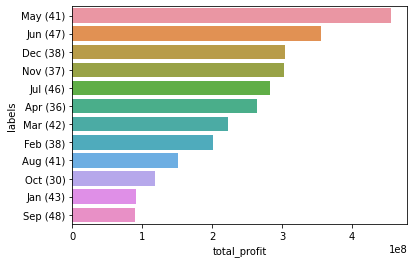

In [37]:
sns.barplot(gbm_df["total_profit"], gbm_df["labels"])